# READ-ME
This is a the a Google Colab notebook for the class **Machine Learning in Bioinformatics**. The runtime type of this notebook is `Python`.

## Before anything else

You must look for the newest version of this course's syllabus and read it.

## Class details

- University: University of North Carolina at Charlotte (UNC Charlotte)
- College: College of Computing and Informatics
- Department: Department of Bioinformatics and Statistics
- Code: BINF 6210 / BINF 8210
- Name: Machine Learning for Bioinformatics (Machine Learning for Bioinformatics - 12328 - BINF 6210 - 001/ Machine Learning for Bioinformatics - 12329 - BINF 8210 - 001)
- Instructor: Denis Jacob Machado, Ph.D.
- Instructor's email: dmachado@uncc.edu
- Instructor's phone: 704-687-8564
- Instructor's office: BINF 453
- Locality: UNC Charlotte's Department of Bioinformatics and Genomics, room 301
- Time: 1:00 pm to 2:15 pm
- Date range: Aug 22, 2022 - Dec 15, 2022 (for approximately 16 weeks)
- Days of the week: TR (Tuesdays and Thursdays)
- Lecture Schedule Type/ Instructional Method: Face-to-Face Instruction Instructional Method
- Credits: 3.0 [credit hours](https://provost.charlotte.edu/policies-procedures/academic-policies-and-procedures/academic-credit-hour) (2,250 minutes of classroom or direct faculty instruction plus 4,500 minutes of out of class student work).

## Copyright

The instructor's lectures and course materials, including presentations, tests, exams, outlines, and similar materials, are protected by copyright. The instructor is the exclusive owner of copyright in those materials the instructor has created. The instructor encourage students to take notes and make copies of course materials for their educational use. However, students may not, nor may they knowingly allow others to reproduce or distribute lecture notes and course materials publicly without the instructor's express written consent. This includes providing materials to commercial course material suppliers such as CourseHero, Chegg, and other similar services. Students who publicly distribute or display or help others publicly distribute or display copies or modified copies of an instructor's course materials may be in violation of University Policy 406, The Code of Student Responsibility. Similarly, students own copyright in their original papers and exam essays. If the instructor is interested in posting the student's answers or papers on the course web site, the instructor will request the student's written permission.

# Combining CNNs and RNNs to process long sequences

## Reference

This notebook is based on "**Deep Learning with Python**," by François Chollet (published by Manning on 2018; ISBN-13: 978-1-61729-443-3).

## Background

These are a few key concepts about deep learning for text and sequences:

- You can use **RNNs** for timeseries regression ("predicting the future"), timeseries classification, anomaly detection in timeseries, and sequence labeling (such as identifying names or dates in sentences).
- Similarly, you can use **1D convnets** for machine translation (sequence-tosequence convolutional models, like SliceNeta), document classification, and spelling correction.
- If **global order matters** in your sequence data, then it’s preferable to use a recurrent network to process it. This is typically the case for timeseries, where the recent past is likely to be more informative than the distant past.
- If **global ordering isn’t fundamentally meaningful**, then 1D convnets will turn out to work at least as well and are cheaper. This is often the case for text data, where a keyword found at the beginning of a sentence is just as meaningful as a keyword found at the end.

## On CNNs and RNNs

Because 1D convnets process input patches independently, they aren't sensitive to the order of timesteps (beyond a local scale, the size of the convolution windows), unlike RNNs. Of course, to recognize longer-term patterns, you can stack many convolution layers and pooling layers, resulting in upper layers that will see long chunks of the original inputs—but that is still a fairly weak way to induce order sensitivity.

One way to evidence this weakness is to try to 1D convnets on the temperature-forecasting problem, were order-sensitivity is key to producing good predictions.

## Data source

Here we will be using the "Jena Climate Dataset," which is a time series forecasting dataset. This is a weather timeseries dataset recorded at the Weather Station of the Max Planck Institute for Biogeochemistry in Jena, Germany. The Jena Climate dataset is made up of 14 different quantities (such air temperature, atmospheric pressure, humidity, wind direction, and so on) recorded every few minutes, over several years. [Click here](https://keras.io/examples/timeseries/timeseries_weather_forecasting/) to read more.

In [1]:
#@title Get access to the files in your drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Get access to the Jena Climate dataset in your drive
#@markdown You must change this path to match the location of the Jena Climate dataset inyour drive.
data_dir = '/content/drive/MyDrive/_CLASSES_/2022_Fall_MachineLearning_UNCCharlotte/Colabs/Jena' #@param {type:"string"}

In [ ]:
#@title Import dependencies and dataset
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
from matplotlib import pyplot as plt
import numpy as np
import os

In [ ]:
#@title Inspecting the data of the Jena weather dataset
#@ You will need a file named `jena_climate_2009_2016.csv` that you can download from [here](https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip) (last accessed on Nov. 28, 2022).
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')
f = open(fname)
data = f.read()
f.close()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print("This is the header: {}".format(', '.join(header)))
print("The dataset contains {} lines.".format(len(lines)))

This is the header: "Date Time", "p (mbar)", "T (degC)", "Tpot (K)", "Tdew (degC)", "rh (%)", "VPmax (mbar)", "VPact (mbar)", "VPdef (mbar)", "sh (g/kg)", "H2OC (mmol/mol)", "rho (g/m**3)", "wv (m/s)", "max. wv (m/s)", "wd (deg)"
The dataset contains 420451 lines.


In [ ]:
#@title Parsing the data
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(',')[1:]]
  float_data[i, :] = values

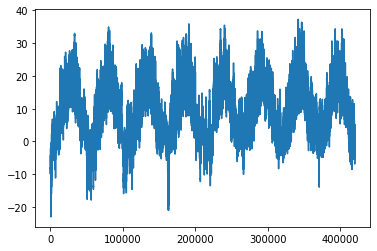

In [ ]:
#@title Plotting the temperature timeseries
#@markdown Here we are vizualizing the temperature over the full temporal range of the dataset in degrees Celsius (ºC)
temp = float_data[:, 1] # temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)

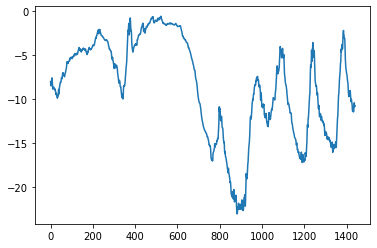

In [ ]:
#@title Plotting the first 10 days of the temperature timeseries
plt.plot(range(1440), temp[:1440])

In [ ]:
#@title Normalizing the data
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [ ]:
#@title Generator yielding timeseries samples and their targets
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
  if max_index is None:
    max_index = len(data) - delay - 1
  i = min_index + lookback
  while 1:
    if shuffle:
      rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
    else:
      if i + batch_size >= max_index:
        i = min_index + lookback
      rows = np.arange(i, min(i + batch_size, max_index))
      i += len(rows)
    samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
    targets = np.zeros((len(rows),))
    for j, row in enumerate(rows):
      indices = range(rows[j] - lookback, rows[j], step)
      samples[j] = data[indices]
      targets[j] = data[rows[j] + delay][1]
    yield samples, targets

In [ ]:
#@title Preparing the training, validation, and test generators
#@markdown Here we define the following variables: `float_data`, `train_gen`, `val_gen`, and `val_steps`.

lookback = 1440
step = 6
delay = 6
batch_size = 128

#train_gen
train_gen = generator(float_data,
  lookback=lookback,
  delay=delay,
  min_index=0,
  max_index=200000,
  shuffle=True,
  step=step,
  batch_size=batch_size)

#val_gen
val_gen = generator(float_data,
  lookback=lookback,
  delay=delay,
  min_index=200001,
  max_index=300000,
  step=step,
  batch_size=batch_size)

#test_gen
test_gen = generator(float_data,
  lookback=lookback,
  delay=delay,
  min_index=300001,
  max_index=None,
  step=step,
  batch_size=batch_size)

#@markdown The variable `val_steps` sets many steps to draw from val_gen in order to see the entire validation set.
val_steps = (300000 - 200001 - lookback)

#@markdown The variable `test_steps` defines many steps to draw from test_gen in order to see the entire test set.
test_steps = (len(float_data) - 300001 - lookback)

In [ ]:
#@title Training and evaluating a simple 1D convnet on the Jena data
model = Sequential()
model.add(layers.Conv1D(
    32,
    5,
    activation='relu',
    input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(
    32,
    5,
    activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(
    32,
    5,
    activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(
    train_gen,
    steps_per_epoch=500,
    epochs=20,
    validation_data=val_gen,
    validation_steps=val_steps)

In [ ]:
#@title Plotting results
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# The road so far

## Interpretation of previous results

The validation MAE stays in the 0.40s: you can’t even beat the common-sense baseline using the small convnet. Again, this is because the convnet looks for patterns anywhere in the input timeseries and has no knowledge of the temporal position of a pattern it sees (toward the beginning, toward the end, and so on). Because more recent data points should be interpreted differently from older data points in the case of this specific forecasting problem, the convnet fails at producing meaningful results. This limitation of convnets isn’t an issue with the IMDB data, because patterns of keywords associated with a positive or negative sentiment are informative independently of where they’re found in the input sentences.

## New strategy

One strategy to combine the speed and lightness of convnets with the order-sensitivity of RNNs is to use a 1D convnet as a preprocessing step before an RNN (see figure 6.30). This is especially beneficial when you’re dealing with sequences that are so long they can’t realistically be processed with RNNs, such as sequences with thousands of steps. The convnet will turn the long input sequence into much shorter (downsampled) sequences of higher-level features. This sequence of extracted features then becomes the input to the RNN part of the network.

This technique isn’t seen often in research papers and practical applications, possibly because it isn’t well known. It’s effective and ought to be more common. Let’s try it on the temperature-forecasting dataset. Because this strategy allows you to manipulate much longer sequences, you can either look at data from longer ago (by increasing the lookback parameter of the data generator) or look at high-resolution timeseries (by decreasing the step parameter of the generator). Here, somewhat arbitrarily, you’ll use a step that’s half as large, resulting in a timeseries twice as long, where the temperature data is sampled at a rate of 1 point per 30 minutes. The example reuses the generator function defined earlier.

In [ ]:
#@title Preparing higher-resolution data generators for the Jena dataset
step = 3
lookback = 720
delay = 144
train_gen = generator(float_data,
  lookback=lookback,
  delay=delay,
  min_index=0,
  max_index=200000,
  shuffle=True,
  step=step)
val_gen = generator(float_data,
  lookback=lookback,
  delay=delay,
  min_index=200001,
  max_index=300000,
  step=step)
test_gen = generator(float_data,
  lookback=lookback,
  delay=delay,
  min_index=300001,
  max_index=None,
  step=step)
val_steps = (300000 - 200001 - lookback) // 128
test_steps = (len(float_data) - 300001 - lookback) // 128

In [ ]:
#@title Model combining a 1D convolutional base and a GRU layer
#@markdown This is the model, starting with two Conv1D layers and following up with a GRU layer.
model = Sequential()
model.add(layers.Conv1D(
    32,
    5,
    activation='relu',
    input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(
    32,
    5,
    activation='relu'))
model.add(layers.GRU(
    32,
    dropout=0.1,
    recurrent_dropout=0.5))
model.add(layers.Dense(1))
model.summary()
model.compile(
    optimizer=RMSprop(),
    loss='mae')
history = model.fit_generator(train_gen,
  steps_per_epoch=500,
  epochs=20,
  validation_data=val_gen,
  validation_steps=val_steps)

In [ ]:
#@title Plotting results
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Wrapping up

These are a few takeways that you should comprehend well after studying this notebook and Chapter 6 of the book "Deep Learning with Python" by François Chollet:

- In the same way that **2D convnets** perform well for processing visual patterns in 2D space, **1D convnets** perform well for processing temporal patterns. They offer a faster alternative to RNNs on some problems, in particular naturallanguage processing tasks.
- Typically, **1D convnets are structured much like their 2D equivalents** from the world of computer vision: they consist of stacks of Conv1D layers and Max-Pooling1D layers, ending in a global pooling operation or flattening operation.
- Because **RNNs are extremely expensive** for processing very long sequences, but **1D convnets are cheap**, it can be a good idea to **use a 1D convnet as a preprocessing step before an RNN**, shortening the sequence and extracting useful representations for the RNN to process.